<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Interactive Bayesian Linear Regression with Metropolis-Hastings  

### Michael J. Pyrcz, Professor, The University of Texas at Austin 

*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

#### Bayesian Updating

The frequentist formulation of the linear regression model is: 

\begin{equation}
y = b_1 \times x + b_0 + \sigma
\end{equation}

where $x$ is the predictor feature, $b_1$ is the slope parameter, $b_0$ is the intercept parameter and $\sigma$ is the error or noise. There is an analytical form for the ordinary least squares solution to fit the available data while minimizing the L2 norm of the data error vector.

For the Bayesian formulation of linear regression is we pose the model as a prediction of the distribution of the response, $Y$, now a random variable:

\begin{equation}
Y \sim N(\beta^{T}X, \sigma^{2} I)
\end{equation}

We estimate the model parameter distributions through Bayesian updating for infering the model parameters from a prior and likelihood from training data.

\begin{equation}
p(\beta | y, X) = \frac{p(y,X| \beta) p(\beta)}{p(y,X)}
\end{equation}

In general for continuous features we are not able to directly calculate the posterior and we must use a sampling method, such as Markov chain Monte Carlo (McMC) to sample the posterior.

For a complete lecture with linked Python workflows check out:

* [Bayesian Linear Regression Lecture](https://www.youtube.com/watch?v=LzZ5b3wdZQk&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=33)

* [Bayesian Probability Lecture](https://www.youtube.com/watch?v=Ppwfr8H177M&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&index=6)

Here's a McMC Metropolis Hastings workflow and more details:

* [Bayesian Linear Regression Workflow](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_BayesianRegression.ipynb)

#### Bayesian Linear Regression with the Metropolis-Hastings Sampler

Here's the basic steps of the Metropolis-Hastings Sampler: 

For $\ell = 1, \ldots, L$:

1. Assign random values for the the initial sample of model parameters, $\beta(\ell = 1) = b_1(\ell = 1)$, $b_0(\ell = 1)$ and $\sigma^2(\ell = 1)$. 
2. Propose new model parameters based on a proposal function, $\beta^{\prime} = b_1$, $b_0$ and $\sigma^2$. 
3. Calculate probability of acceptance of the new proposal, as the ratio of the posterior probability of the new model parameters given the data to the previous model parameters given the data multiplied by the probability of the old step given the new step divided by the probability of the new step given the old. 

\begin{equation}
P(\beta \rightarrow \beta^{\prime}) = min\left(\frac{p(\beta^{\prime}|y,X) }{ p(\beta | y,X)} \cdot \frac{p(\beta^{\prime}|\beta) }{ p(\beta | \beta^{\prime})},1\right)
\end{equation}

4. Apply Monte Carlo simulation to conditionally accept the proposal, if accepted, $\ell = \ell + 1$, and sample $\beta(\ell) = \beta^{\prime}$
5. Go to step 2.

Let's talk about this system. First the left hand side:

\begin{equation}
\frac{p(\beta^{\prime}|y,X) }{ p(\beta | y,X)}
\end{equation}

We are calculating the ratio of the posterior probability (likelihood times prior) of the model parameters given the data and prior model for proposed sample over the current sample. 

* As you will see below it is quite practical to calculate this ratio.
* If the proposed sampled is more likely than the current sample, we will have a value greater than 1.0, it will truncate to 1.0 and we accept the proposed sample.
* If the proposed sample is less likely than the current sample, we will have a value less than 1.0, then we will use Monte Carlo sampling to randomly choice the proposed sample with this probability of acceptance.

This proceedure allows us to walk through the model parameter space and sample the parameters with the current rates, after the burn-in chain.

Now, what about this part of the equation?

\begin{equation}
\frac{p(\beta^{\prime}|\beta) }{ p(\beta | \beta^{\prime})}
\end{equation}

There is a problem with this procedure if we use asymmetric probability distributions for the model parameters! 

* E.g. for example, if we use a positively skewed distribution (e.g., log normal) then we are more likely to step to larger values due to this distribution, and not due to the prior nor the likelihood.

* This term removes this bias, so that we have fair samples!

You will see below that we remove this issue by assuming symmetric model parameter distributions, even though many use  na assymetric gamma distribution for sigma, given it cannot have negative values.

* My goal is the simplest possible demonstration.

#### Our Simplified Demonstration Metropolis Sampling

Let's further specify this workflow for our simple demonstration. 

1. I have assumed a Gaussian, symmetric distribution for all model parameters as a result this relationship holds for all possible model parameter, current and proposed.

\begin{equation}
\frac{p(\beta^{\prime}|\beta) }{ p(\beta | \beta^{\prime})} = 1.0
\end{equation}

    So we now have this simplified probability of proposal acceptance, note this is know as Metropolis Sampling.
    
\begin{equation}
P(\beta \rightarrow \beta^{\prime}) = min \left( \frac{p(\beta^{\prime}|y,X) }{ p(\beta | y,X)},1 \right) 
\end{equation}

2. Now, let's substitute our Bayesian formulation for our Bayesian linear regression model.

\begin{equation}
p(\beta^{\prime} | y, X) = \frac{p(y,X| \beta^{\prime}) p(\beta^{\prime})}{p(y,X)} \quad \text{      and        } \quad p(\beta | y, X) = \frac{p(y,X| \beta) p(\beta)}{p(y,X)}
\end{equation}

    If we substitute these into our probability of acceptance above we get this.


\begin{equation}
P(\beta \rightarrow \beta^{\prime}) = min \left( \frac{p(\beta^{\prime}|y,X) }{ p(\beta | y,X)},1 \right) = min \left( \frac{ \left( \frac{p(y,X| \beta_{new}) p(\beta_{new}) } {p(y,X)} \right) }{ \left( \frac{ p(y,X| \beta) p(\beta)}{p(y,X)} \right) },1 \right)
\end{equation}

    Note that the evidence terms cancel out.

\begin{equation}
P(\beta \rightarrow \beta^{\prime}) = min \left( \frac{ p(y,X| \beta_{new}) p(\beta_{new}) }{ p(y,X| \beta) p(\beta)},1 \right)
\end{equation}

    Since we are working with a likelihood ratio, we can work with densities instead of probabilities.

\begin{equation}
P(\beta \rightarrow \beta^{\prime}) = min \left( \frac{ f(y,X| \beta_{new}) f(\beta_{new}) }{ f(y,X| \beta) f(\beta) } ,1 \right)
\end{equation}

3. Finally for improved solution stability we can calculate the natural log ratio:

\begin{equation}
ln(P(\beta \rightarrow \beta^{\prime})) = min \left( ln \left[ \frac{ f(y,X| \beta_{new}) f(\beta_{new}) }{ f(y,X| \beta) f(\beta) } \right],0 \right) = min \left( \left[ln(f(y,X| \beta_{new})) + ln(f(\beta_{new})) \right] - \left[ ln(f(y,X| \beta)) + ln(f(\beta)) \right],0 \right)
\end{equation}

4. We calculate probability of proposal acceptance, as exponentiation of the above. 

5. How do we calculate the likelihood density? If we assume independence between all of the data we can take the product sum of the probabilities (densities) of all the response values given the predictor and model parameter sample! Given, the Gaussian assumption for the response feature, we can calculate the densities for each data from the Gaussian PDF.

\begin{equation}
f_{y,X | \beta}(y) \sim N [ b_1 \cdot X + b_0, \sigma ]
\end{equation}

    and under the assumption of indepedence we can take the produce sum over all training data.

\begin{equation}
f(y,X| \beta) = \prod_{\alpha = 1}^{n} f_{y,X | \beta}(y_{\alpha})
\end{equation}

Note, this workflow was developed with assistance from Fortunato Nucera's Medium Article [Mastering Bayesian Linear Regression from Scratch: A Metropolis-Hastings Implementation in Python](https://medium.com/@tinonucera/bayesian-linear-regression-from-scratch-a-metropolis-hastings-implementation-63526857f191). I highly recommend this accessible description and demonstration. Thank you, Fortunato.

#### Load and Configure the Required Libraries

The following code loads the required libraries and sets a plotting default.

In [1]:
import numpy as np                                          # arrays and matrix math
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from matplotlib.patches import Rectangle                    # build a custom legend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import seaborn as sns                                   # plot PDF
import scipy.stats as stats                                 # parametric distributions
from sklearn.linear_model import LinearRegression           # frequentist model for comparison
from IPython.display import display_markdown                # add markdown to code outputs 
plt.rc('axes', axisbelow=True)                              # set axes and grids in the background for all plots
import warnings
warnings.filterwarnings('ignore')                           # ignore warnings
seed = 73073                                                # random number seed

#### Declare Functions

The following functions include:
    
* **next_proposal** - propose a next model parameters from previous previous model parameters, this is the proposal method, parameterized by step standarrd deviation and Gaussian distribution.

* **likelihood_density** - calculate the product of all the densities for all the data given the model parameters. Since we are working with the log densities, we sum over all the data.

* **prior_density** - calculate the product of the densities for all the model parameters given the prior model. Since we are working with the log densities, we sum over all the model parameters. This is an assumption of independence.

* **add_grid** - improved grid for the plotting.

In [2]:
def next_proposal(prev_theta, step_stdev = 0.5):            # assuming a Gaussian distribution centered on previous theta and step stdev  
    out_theta = stats.multivariate_normal(mean=prev_theta,cov=np.eye(3)*step_stdev**2).rvs(1)
    return out_theta

def likelihood_density(x,y,theta):                          # likelihood - probability (density) of the data given the model
    density = np.sum(stats.norm.logpdf(y, loc=theta[0]*x+theta[1],scale=theta[2])) # assume independence, sum is product in log space
    return density

def prior_density(theta,prior):                             # prior - probability (density) of the model parameters given the prior 
    mean = np.array([prior[0,0],prior[1,0],prior[2,0]]); cov = np.zeros([3,3]); cov[0,0] = prior[0,1]; cov[1,1] = prior[1,1]; cov[2,2] = prior[2,1]
    prior_out = stats.multivariate_normal.logpdf(theta,mean=mean,cov=cov,allow_singular=True)
    return prior_out

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

#### Build a Dataset with Known Truth Model Parameters for Linear Regression

Let's build a simple dataset with known linear regresin parameters, $b_1$ is the slope parameter, $b_0$ is the intercept parameter and $\sigma$ is the error or noise.

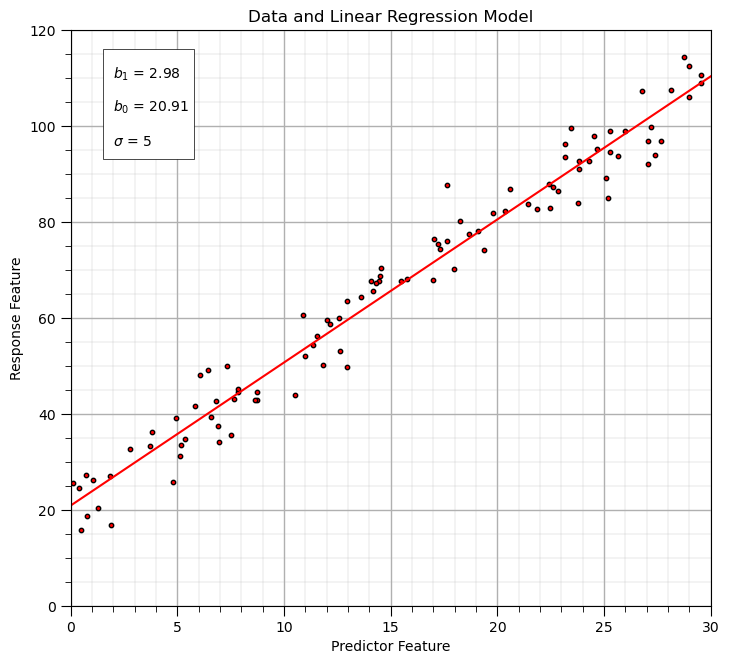

In [28]:
np.random.seed(seed = seed)                                 # set random number seed

data_b1 = 3; data_b0 = 20; data_sigma = 5; n = 100          # set data model parameters

x = np.random.rand(n)*30                                    # random x values
y = data_b1*x+data_b0 + np.random.normal(loc=0.0,scale=data_sigma,size=n) # y as a linear function of x + random noise 

xhat = np.linspace(-10,40,100)                              # set of x values to predict and visualize the model
linear_model = LinearRegression().fit(x.reshape(-1, 1),y)   # instantiate and train the frequentist linear regression model
yhat = linear_model.predict(xhat.reshape(-1, 1))            # make predictions for model plotting

plt.subplot(111)
plt.scatter(x, y,c='red',s=10,edgecolor='black')
plt.plot(xhat,yhat,c='red'); add_grid()
plt.xlabel("Predictor Feature"); plt.ylabel("Response Feature"); plt.title('Data and Linear Regression Model')
plt.gca().add_patch(Rectangle((1.5,93.0),4.3,23,facecolor='white',edgecolor='black',linewidth=0.5))
plt.annotate('$b_1$ = ' + str(np.round(linear_model.coef_[0],2)),[2,110])
plt.annotate('$b_0$ = ' + str(np.round(linear_model.intercept_,2)),[2,103])
plt.annotate('$\sigma$ = ' + str(np.round(data_sigma,2)),[2,96])
plt.xlim([0,30]); plt.ylim([0,120])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.5); plt.show()

#### Assume the Prior Model

We assume a multivariate Gaussian distribution for the slope and intercept parameters, $f_{b_1,b_0,\sigma}(b_1,b_0,\sigma)$ with indepedence between $b_1$, $b_0$, and $\sigma$.

* For a naive prior assume a very large standard deviation.
We will work in log probability and log density to improve stability of the system. 

* We want to avoid product sums of a many values near zero as the the probabilities will disappear due to computer floating point precision. 
* In log space, we can add calculate probabilities of independent events by summing (instead of multiplication) these negative values 

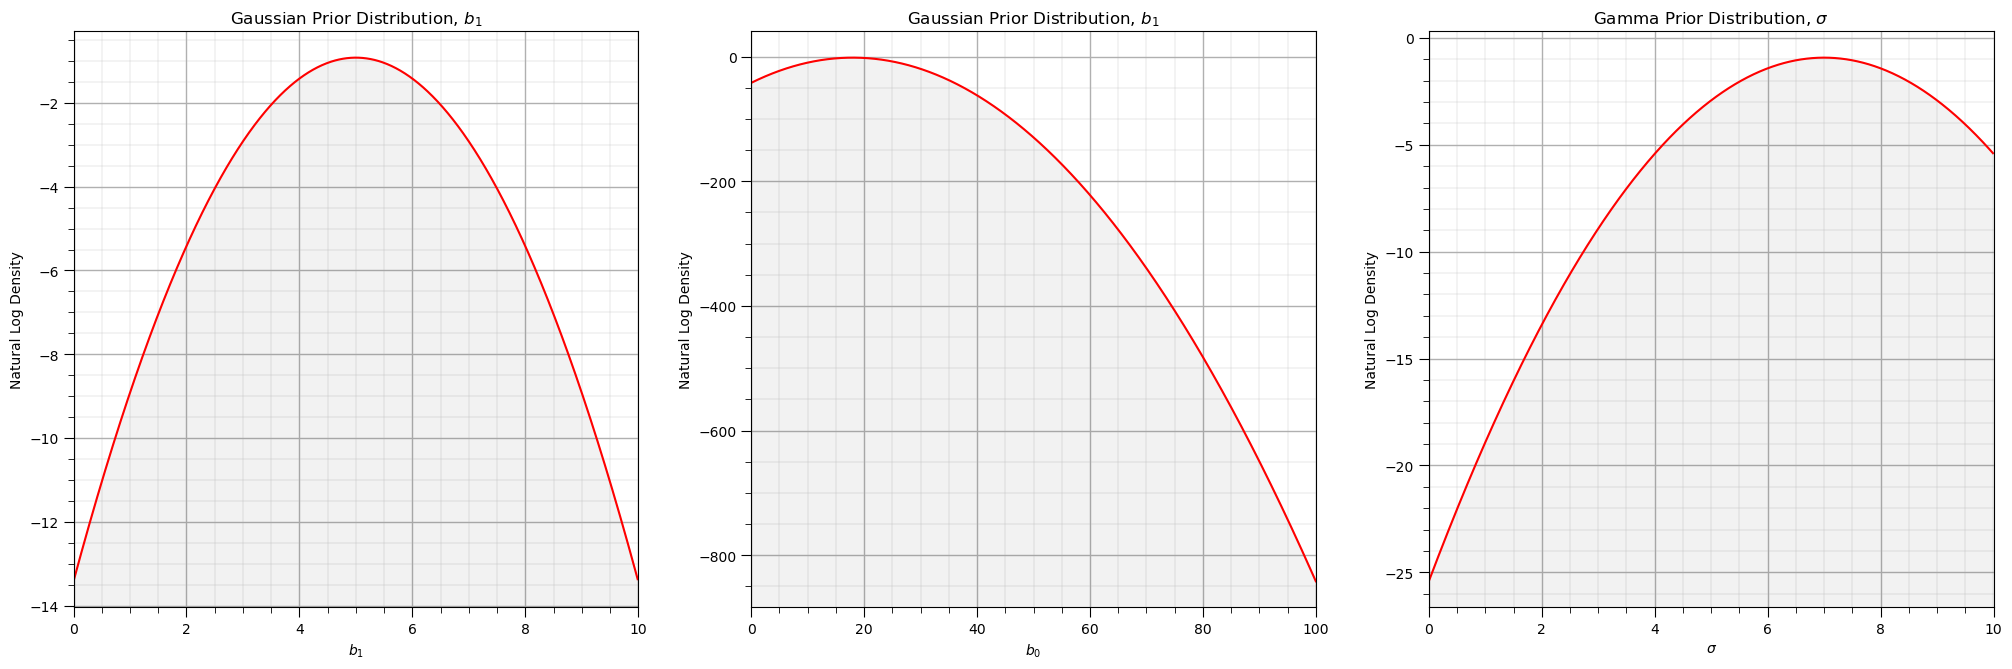

In [30]:
prior = np.zeros([3,2])                                     # prior distributions
prior[0,:] = [5.0,1.0]                                      # Gaussian prior model for slope, mean and standard deviation
prior[1,:] = [18.0,2.0]                                     # Gaussian prior model for intercept, mean and standard deviation
prior[2,:] = [7.0,1.0]                                      # Gaussian prior model for sigma, k (shape) and phi (scale), recall mean = k x phi, var = k x phi^2 

plt.subplot(131)                                            # slope prior distribution
plt.plot(np.arange(0,10,0.01),stats.norm.logpdf(np.arange(0,10,0.01),loc=prior[0,0],scale=prior[0,1]),c='red'); ylim = plt.gca().get_ylim() 
plt.fill_between(np.arange(0,10,0.01),np.full(1000,-1.0e20),stats.norm.logpdf(np.arange(0,10,0.01),loc=prior[0,0],scale=prior[0,1]),color='black',alpha=0.05,zorder=1)
plt.xlabel(r'$b_1$'); plt.ylabel('Natural Log Density'); plt.title("Gaussian Prior Distribution, $b_1$"); add_grid(); plt.xlim([0,10]); plt.ylim(ylim)

plt.subplot(132)                                            # intercept prior distribution
plt.plot(np.arange(0,100,0.01),stats.norm.logpdf(np.arange(0,100,0.01),loc=prior[1,0],scale=prior[1,1]),c='red'); ylim = plt.gca().get_ylim() 
plt.fill_between(np.arange(0,100,0.01),np.full(10000,-1.0e20),stats.norm.logpdf(np.arange(0,100,0.01),loc=prior[1,0],scale=prior[1,1]),color='black',alpha=0.05,zorder=1)
plt.xlabel(r'$b_0$'); plt.ylabel('Natural Log Density'); plt.title("Gaussian Prior Distribution, $b_1$"); add_grid(); plt.xlim([0,100]); plt.ylim(ylim)

plt.subplot(133)                                            # noise prior distribution
plt.plot(np.arange(0,10,0.01),stats.norm.logpdf(np.arange(0,10,0.01),loc=prior[2,0],scale=prior[2,1]),c='red'); ylim = plt.gca().get_ylim() 
plt.fill_between(np.arange(0,10,0.01),np.full(1000,-1.0e20),stats.norm.logpdf(np.arange(0,10,0.01),loc=prior[2,0],scale=prior[2,1]),color='black',alpha=0.05,zorder=1)
plt.xlabel(r'$\sigma$'); plt.ylabel('Natural Log Density'); plt.title("Gamma Prior Distribution, $\sigma$"); add_grid(); plt.xlim([0,10]); plt.ylim(ylim)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.5); plt.show()

#### Bayesian Linear Regression with McMC Metropolis-Hastings 

The Bayesian linear regression with McMC Metropolis-Hastings workflow.

1. assign an random initial set of model parameters
2. apply a proposal rule to assign a new set of model parameters given the previous set of model paramters
3. calculate the ratio of the likelihood of the new model parameters over the previous model parameters given the data
4. conditionally accept the proposal based on this ratio, i.e., if proposal is more like accept it, if less likely with a probability based on the ratio.
5. goto to 2.

In [5]:
np.random.seed(seed = seed)
step_stdev = 0.2

thetas = np.random.rand(3).reshape(1,-1) # seed a random first step
accepted = 0

n = 10000                                                    # number of attempts

for i in range(n):
    theta_new = next_proposal(thetas[-1,:],step_stdev=step_stdev) # next proposal
    
    log_like_new = likelihood_density(x,y,theta_new)        # new and prior likelihoods, log of density
    log_like = likelihood_density(x,y,thetas[-1,:])
        
    log_prior_new = prior_density(theta_new,prior)          # new and prior prior, log of density
    log_prior = prior_density(thetas[-1,:],prior)
    
    likelihood_prior_proposal_ratio = np.exp((log_like_new + log_prior_new) - (log_like + log_prior)) # calculate log ratio

    if likelihood_prior_proposal_ratio > np.random.rand(1): # conditionally accept by likelihood ratio
        thetas = np.vstack((thetas,theta_new)); accepted += 1

print('Accepted ' + str(accepted) + ' samples of ' + str(n) + ' attempts')

df = pd.DataFrame(np.vstack([thetas[:,0],thetas[:,1],thetas[:,2]]).T, columns= ['Slope','Intercept','Sigma'])

Accepted 1784 samples of 10000 attempts


#### Visualize the Results

Let's visualize the McMC Metropolis sample chain for each of the model parameters.

* Note the burn-in and equalibrium chains.

* Compare the slope and intercept model parameters to the frequentiest, linear regression solution, based only on the ordinary least squares solution, minimizing the L2 norm of the error vector over all sample data.

* Compare the noise parameter to the noise added to the synthetic data.

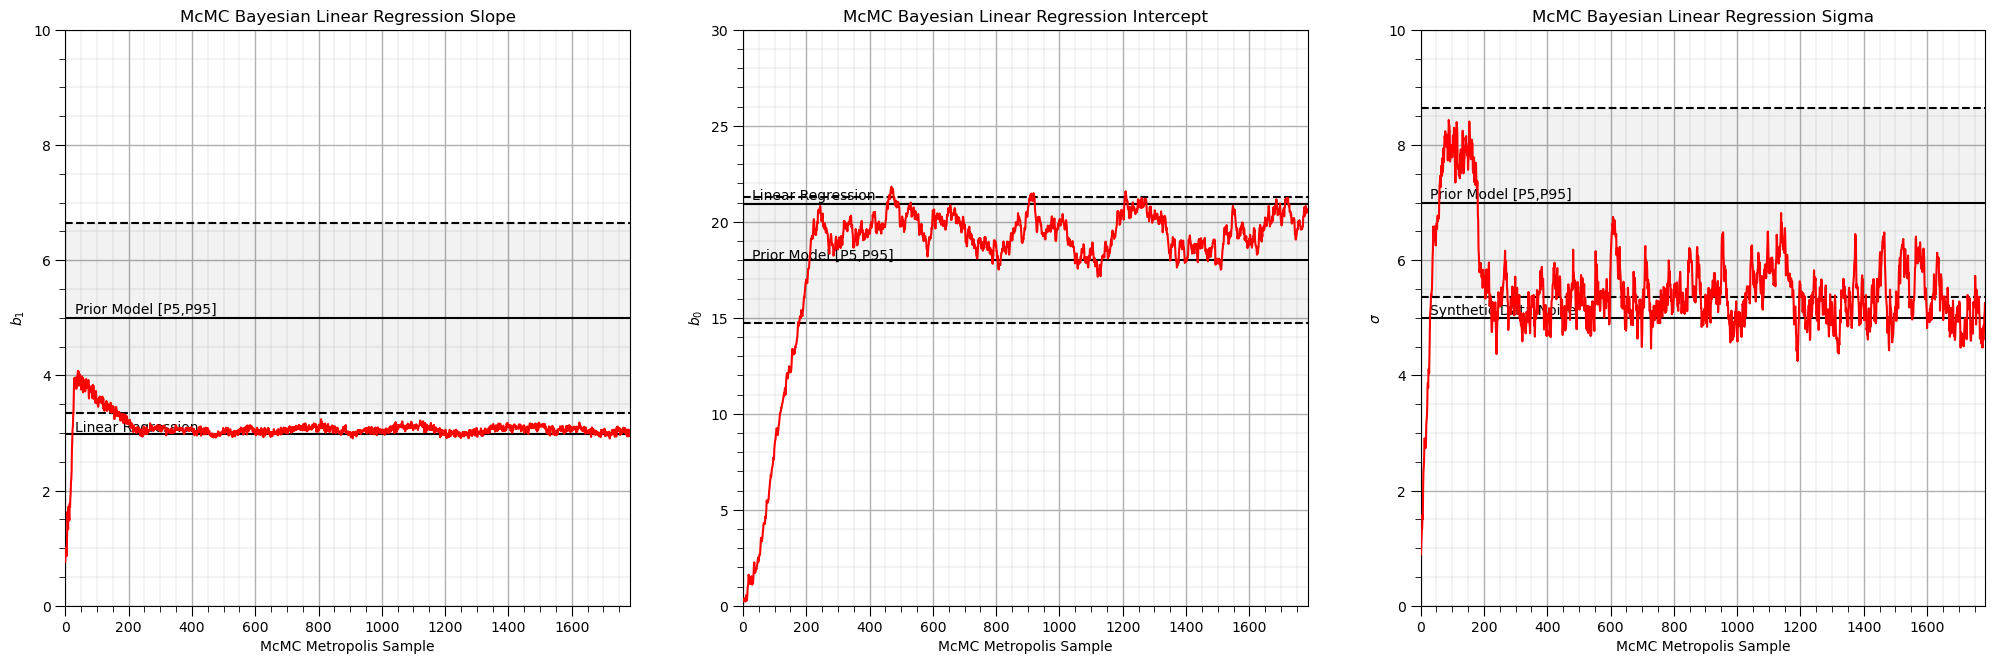

In [9]:
alpha = 0.1

plt.subplot(131)
plt.plot(np.arange(0,accepted+1,1),thetas[:,0],c='red',zorder=100) 
plt.xlabel('McMC Metropolis Sample'); plt.ylabel(r'$b_1$'); plt.title("McMC Bayesian Linear Regression Slope"); add_grid()
plt.plot([0,accepted],[linear_model.coef_[0],linear_model.coef_[0]],c='black',zorder=10)
plt.annotate('Linear Regression',[30,linear_model.coef_[0]+0.05])
plt.plot([0,accepted],[prior[0,0],prior[0,0]],c='black',zorder=10)
plt.annotate('Prior Model [P' + str((int(alpha/2*100))) + ',P' + str((int((1.0-alpha/2)*100))) + ']',[30,prior[0,0]+0.07])
lower = stats.norm.ppf(alpha/2.0,loc=prior[0,0],scale=prior[0,1])
plt.plot([0,accepted],[lower,lower],c='black',ls='--',zorder=10)
upper = stats.norm.ppf(1-alpha/2.0,loc=prior[0,0],scale=prior[0,1])
plt.plot([0,accepted],[upper,upper],c='black',ls='--',zorder=10)
plt.fill_between([0,accepted],[lower,lower],[upper,upper],color='black',alpha=0.05,zorder=1)
plt.xlim([0,accepted]); plt.ylim([0,10])

plt.subplot(132)
plt.plot(np.arange(0,accepted+1,1),thetas[:,1],c='red',zorder=100) 
plt.xlabel('McMC Metropolis Sample'); plt.ylabel(r'$b_0$'); plt.title("McMC Bayesian Linear Regression Intercept"); add_grid()
plt.plot([0,accepted],[linear_model.intercept_,linear_model.intercept_],c='black',zorder=10)
plt.annotate('Linear Regression',[30,linear_model.intercept_+0.25])
plt.plot([0,accepted],[prior[1,0],prior[1,0]],c='black',zorder=10)
plt.annotate('Prior Model [P' + str((int(alpha/2*100))) + ',P' + str((int((1.0-alpha/2)*100))) + ']',[30,prior[1,0]+0.07])
lower = stats.norm.ppf(alpha/2.0,loc=prior[1,0],scale=prior[1,1])
plt.plot([0,accepted],[lower,lower],c='black',ls='--',zorder=10)
upper = stats.norm.ppf(1-alpha/2.0,loc=prior[1,0],scale=prior[1,1])
plt.plot([0,accepted],[upper,upper],c='black',ls='--',zorder=10)
plt.fill_between([0,accepted],[lower,lower],[upper,upper],color='black',alpha=0.05,zorder=1)
plt.xlim([0,accepted]); plt.ylim([0,30])

plt.subplot(133)
plt.plot(np.arange(0,accepted+1,1),thetas[:,2],c='red',zorder=100) 
plt.xlabel('McMC Metropolis Sample'); plt.ylabel(r'$\sigma$'); plt.title("McMC Bayesian Linear Regression Sigma"); add_grid()
plt.plot([0,accepted],[data_sigma,data_sigma],c='black',zorder=10)
plt.annotate('Synthetic Data Noise',[30,data_sigma+0.06])
plt.plot([0,accepted],[prior[2,0],prior[2,0]],c='black',zorder=10)
plt.annotate('Prior Model [P' + str((int(alpha/2*100))) + ',P' + str((int((1.0-alpha/2)*100))) + ']',[30,prior[2,0]+0.07])
lower = stats.norm.ppf(alpha/2.0,loc=prior[2,0],scale=prior[2,1])
plt.plot([0,accepted],[lower,lower],c='black',ls='--',zorder=10)
upper = stats.norm.ppf(1-alpha/2.0,loc=prior[2,0],scale=prior[2,1])
plt.plot([0,accepted],[upper,upper],c='black',ls='--',zorder=10)
plt.fill_between([0,accepted],[lower,lower],[upper,upper],color='black',alpha=0.05,zorder=1)
plt.xlim([0,accepted]); plt.ylim([0,10])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.5); plt.show()

#### Visualize the Chain in the Model Parameter Space

Set the burn-in chain as the accepted sample at the end of the burn in chain and observed the McMC sampling.

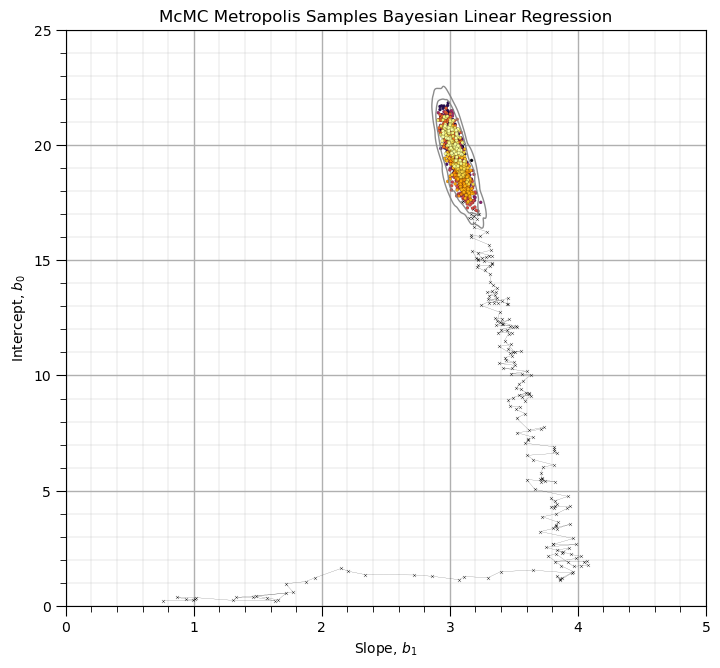

In [7]:
burn_chain = 250
plt.scatter(thetas[:burn_chain,0],thetas[:burn_chain,1],s=5,marker = 'x',c='black',alpha=0.8,linewidth=0.3,cmap=plt.cm.inferno,zorder=10)
plt.scatter(thetas[burn_chain:,0],thetas[burn_chain:,1],s=5,c=np.arange(burn_chain,accepted+1,1),alpha=1.0,edgecolor='black',linewidth=0.1,cmap=plt.cm.inferno,zorder=10)
sns.kdeplot(data=df[burn_chain:],x='Slope',y='Intercept',color='grey',linewidths=1.00,alpha=0.9,levels=np.logspace(-4,-0,3),zorder=100)
plt.plot(thetas[:burn_chain,0],thetas[:burn_chain,1],color='black',linewidth=0.1,zorder=1)
add_grid(); plt.xlabel('Slope, $b_1$'); plt.ylabel('Intercept, $b_0$'); plt.title('McMC Metropolis Samples Bayesian Linear Regression') 
plt.xlim([0,5]); plt.ylim([0,25])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.5); plt.show()

#### Comments

This was a demonstration of Bayesian Linear Regression with McMC Metropolis-Hastings Sampling.

I have many other demonstrations on data analytics and machine learning, e.g. on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael J Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
